# ARM and Networking

The data we are using for this analysis is the Violence Project's Mass Shooter Database.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from apyori import apriori
import networkx as nx 

In [2]:
msdb = pd.read_csv("./../../data/02-clean-data/MSDB/school_shooters.csv")
msdb.head()

,Incident_ID,Full.Date.SSDB,Case..,Shooter.Last.Name,Shooter.First.Name,Full.Date,Day.of.Week,Day,Month,Year,...,Interest.in.Firearms,Firearm.Proficiency,Total.Firearms.Brought.to.the.Scene,Other.Weapons.or.Gear,Specify.Other.Weapons.or.Gear,On.Scene.Outcome,Attempt.to.Flee,Insanity.Defense,Criminal.Sentence,X
0,NaN,1966-08-01,1,Whitman,Charles,8/1/66,Monday,1,8,1966,...,1,3,7,1,"hatchet, hammer, knives, wrench, ropes, water,...",1,0,2,0.0,NaN
1,NaN,1976-07-12,11,Allaway,Edward,7/12/76,Monday,12,7,1976,...,0,3,1,0,NaN,2,0,1,4.0,NaN
2,19880922ILMOC,1988-09-22,36,Henderson,Clemmie,9/22/88,Thursday,22,9,1988,...,0,3,1,0,NaN,1,0,2,0.0,NaN
3,19890117CACLS,1989-01-17,37,Purdy,Patrick,1/17/89,Tuesday,17,1,1989,...,1,1,2,1,"ammo pouch, ear plugs, flak jacket, pipe bomb,...",0,0,2,0.0,NaN
4,NaN,1991-11-01,42,Lu,Gang,11/1/91,Friday,1,11,1991,...,1,1,2,0,NaN,0,0,2,0.0,NaN


We need to organize the dataset into a list of lists. Because the order of the lists in the second dimension don't matter, we need to apply meaning to each of the numeric levels used in many of these columns. We can do this by appending the name of the column onto each value in the dataset. However, before doing this we will remove any columns that show no similarities between shooters or are textual.

In [3]:
drop_cols = [
    'Incident_ID',
    'Full.Date.SSDB',
    'Case..',
    'Shooter.Last.Name',
    'Shooter.First.Name',
    'Full.Date',
    'Day',
    'Year',
    'Shooting.Location.Address',
    'City',
    'State',
    'State.Code',
    'Workplace.shooting', # None are workplace shootings
    'Number.Killed', # Quantitative
    'Number.Injured', # Quantitative
    'Age', # Quantitative
    'Gender', # All male
    'School.Performance.Specified', # All unique values / text descriptions
    'Community.Involvement.Specified', # All unique values / text descriptions
    'Gang.Affiliation', # No evidence
    'Terror.Group.Affiliation', # No evidence
    'Family.Member.Incarcerated', # No evidence
    'Signs.of.Crisis.Expanded', # All unique values / text descriptions
    'Psychiatric.Medication.Specified', # All unique values / text descriptions
    'Health.Issues...Specify', # All unique values / text descriptions
    'Motive..Unknown', # Not informative for this analysis
    'Specify.Relationship.to.Other.Shooting.s.', # All unique values / text descriptions
    'Specify.Pop.Culture.Connection', # All unique values / text descriptions
    'Total.Firearms.Brought.to.the.Scene', # Quantitative
    'Specify.Other.Weapons.or.Gear', # All unique values / text descriptions
    'X'
]

msdb.drop(columns=drop_cols, inplace=True)

Although the day of the week is textual/string, there may be value in keeping it. We will convert the column to integer-based levels.

In [4]:
# Clean Day.of.Week--change to integers
def weekday_to_int(weekday):
    match weekday:
        case "Monday":
            return 1
        case "Tuesday":
            return 2
        case "Wednesday":
            return 3
        case "Thursday":
            return 4
        case "Friday":
            return 5
        case "Saturday":
            return 6
        case "Sunday":
            return 7
        case _:
            return 0

msdb['Day.of.Week'] = msdb['Day.of.Week'].apply(weekday_to_int)

Now we will: 
* Save the column names
* Convert the dataframe to a list of lists
* Split string elements separated by comma
* Drop 0s and NaNs
* Drop decimal points from all values
* Append/concatenate each value with the original column names elementwise

In [5]:
colnames = msdb.columns.tolist()
msdb_lists = msdb.values.tolist()

msdb_data = []

for var in msdb_lists:
    var_new = []
    for col_num, i in enumerate(var):
        if (',' in str(i)):
            sub_list_string = i.split(',')
            sub_list_string = [str(int(i)) + colnames[col_num] for i in sub_list_string]
            var_new += sub_list_string
        elif all([i != 0, i != '0', math.isnan(float(i)) != True]):
            var_new.append(str(int(i)) + colnames[col_num])
    msdb_data.append(var_new)

We will now convert the data to a NetworkX object to perform ARM. The code from this chunk is heavily referenced from Dr. James' sample code.

In [112]:
def reformat_results(results):

    #CLEAN-UP RESULTS 
    keep=[]
    for i in range(0,len(results)):
        # print("=====================================")
        # print(results[i])
        # print(len(list(results[i])))
        for j in range(0,len(list(results[i]))):
            # print(results)
            if(j>1):
                for k in range(0,len(list(results[i][j]))):
                    if(len(results[i][j][k][0])!=0):
                        #print(len(results[i][j][k][0]),results[i][j][k][0])
                        rhs=list(results[i][j][k][0])
                        lhs=list(results[i][j][k][1])
                        conf=float(results[i][j][k][2])
                        lift=float(results[i][j][k][3])
                        keep.append([rhs,lhs,supp,conf,supp*conf,lift])
                        # keep.append()
            if(j==1):
                supp=results[i][j]

    return pd.DataFrame(keep, columns =["rhs","lhs","supp","conf","supp x conf","lift"])

def convert_to_network(df):
    print(df)

    #BUILD GRAPH
    G = nx.DiGraph()  # DIRECTED
    for row in df.iterrows():
        # for column in df.columns:
        lhs="_".join(row[1][0])
        rhs="_".join(row[1][1])
        conf=row[1][3]; #print(conf)
        if(lhs not in G.nodes): 
            G.add_node(lhs)
        if(rhs not in G.nodes): 
            G.add_node(rhs)

        edge=(lhs,rhs)
        if edge not in G.edges:
            G.add_edge(lhs, rhs, weight=conf)

    # print(G.nodes)
    # print(G.edges)
    return G

def plot_network(G, filepath, plot_title):
    plt.rcParams['figure.figsize'] = [16,9]
    plt.rcParams['font.size'] = 20

    #SPECIFIY X-Y POSITIONS FOR PLOTTING
    pos=nx.circular_layout(G)

    #GENERATE PLOT
    fig, ax = plt.subplots()

    #assign colors based on attributes
    weights_e 	= [G[u][v]['weight'] for u,v in G.edges()]

    #SAMPLE CMAP FOR COLORS 
    cmap=plt.cm.get_cmap('Blues')
    colors_e 	= [cmap(G[u][v]['weight']/5.0) for u,v in G.edges()]

    #PLOT
    nx.draw(
    G,
    edgecolors="black",
    edge_color="black",
    node_color = '#228b22',
    node_size=2000,
    linewidths=4,
    font_color="white",
    font_size = 22,
    font_weight="bold",
    width=weights_e,
    with_labels=True,
    pos=pos,
    ax=ax
    )
    ax.set(title=plot_title)
    # ax.set_aspect('equal', 'box')
    # plt.colorbar(cmap)

    fig.savefig(filepath)
    plt.show()

                                                  rhs  \
0                              [1Increased.Agitation]   
1                               [1Insider...Outsider]   
2                              [1Increased.Agitation]   
3                         [1Signs.of.Being.in.Crisis]   
4                               [1Insider...Outsider]   
5                                         [1Planning]   
6                               [1Insider...Outsider]   
7                         [1Signs.of.Being.in.Crisis]   
8                                         [1Planning]   
9                         [1Signs.of.Being.in.Crisis]   
10                             [1Increased.Agitation]   
11                              [1Insider...Outsider]   
12                        [1Signs.of.Being.in.Crisis]   
13        [1Insider...Outsider, 1Increased.Agitation]   
14  [1Signs.of.Being.in.Crisis, 1Increased.Agitation]   
15   [1Signs.of.Being.in.Crisis, 1Insider...Outsider]   

                              

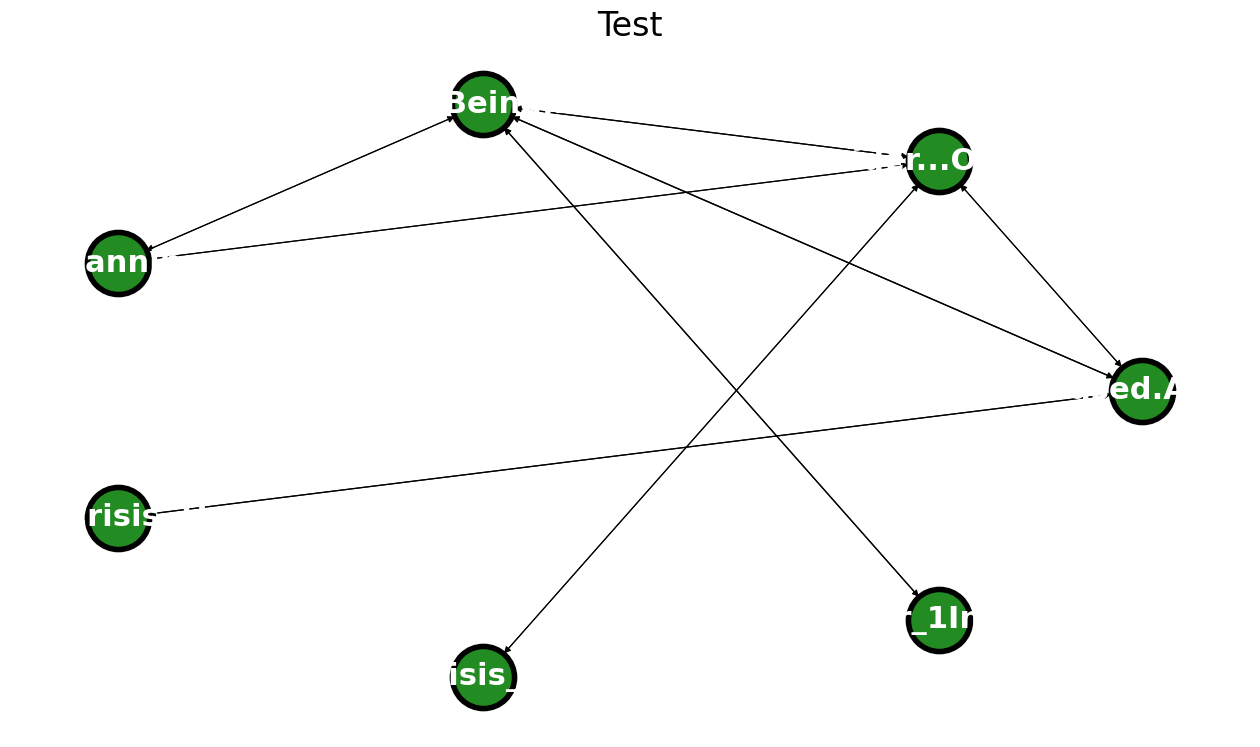

                                                  rhs  \
2                              [1Increased.Agitation]   
3                         [1Signs.of.Being.in.Crisis]   
6                               [1Insider...Outsider]   
7                         [1Signs.of.Being.in.Crisis]   
8                                         [1Planning]   
9                         [1Signs.of.Being.in.Crisis]   
0                              [1Increased.Agitation]   
1                               [1Insider...Outsider]   
4                               [1Insider...Outsider]   
5                                         [1Planning]   
10                             [1Increased.Agitation]   
11                              [1Insider...Outsider]   
12                        [1Signs.of.Being.in.Crisis]   
13        [1Insider...Outsider, 1Increased.Agitation]   
14  [1Signs.of.Being.in.Crisis, 1Increased.Agitation]   
15   [1Signs.of.Being.in.Crisis, 1Insider...Outsider]   

                              

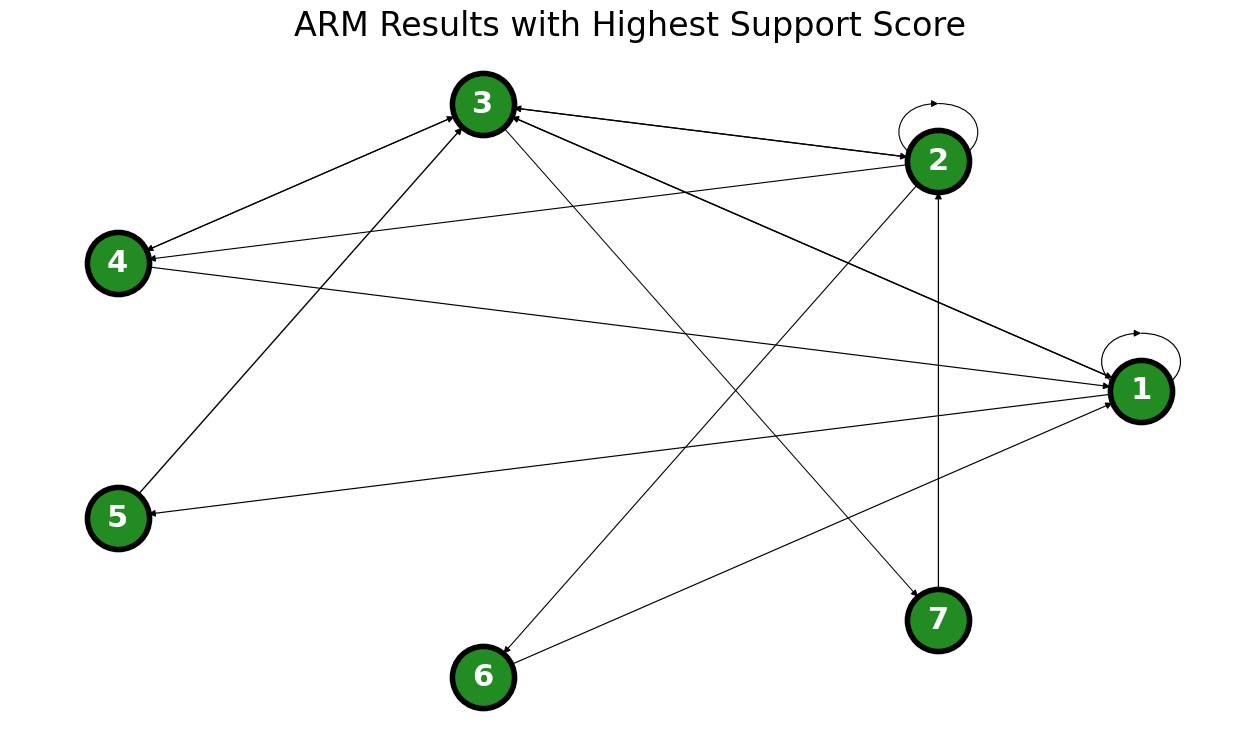

Index(['['1Increased.Agitation']', '['1Insider...Outsider']',
       '['1Signs.of.Being.in.Crisis']', '['1Planning']',
       '['1Insider...Outsider', '1Increased.Agitation']',
       '['1Signs.of.Being.in.Crisis', '1Increased.Agitation']',
       '['1Signs.of.Being.in.Crisis', '1Insider...Outsider']'],
      dtype='object')


In [119]:
results = list(apriori(msdb_data, min_support=0.65, min_confidence=0.0, min_lift=0, min_length=1))     # Don't go below 0.3 support 0.4 confidence
pd_results=reformat_results(results)
G=convert_to_network(pd_results)
plot_network(G, './test.png', "Test")

print(pd_results.sort_values('supp', ascending = False))

pd_results['rhs'], rhs_index = pd.factorize(pd_results['rhs'].astype(str))
pd_results['rhs'] = pd_results['rhs'].apply(lambda x: [str(x+1)])
pd_results['lhs'], lhs_index = pd.factorize(pd_results['lhs'].astype(str))
pd_results['lhs'] = pd_results['lhs'].apply(lambda x: [str(x+1)])

H=convert_to_network(pd_results)
plot_network(H, "./../../501-project-website/images/arm/top_support.png", "ARM Results with Highest Support Score")

print(rhs_index)

                                            rhs                          lhs  \
0                           [1Abusive.Behavior]  [1Signs.of.Being.in.Crisis]   
1                        [1Increased.Agitation]  [1Signs.of.Being.in.Crisis]   
2                                [3Birth.Order]        [1Insider...Outsider]   
3                                  [1Isolation]  [1Signs.of.Being.in.Crisis]   
4                     [1Notably.Depressed.Mood]  [1Signs.of.Being.in.Crisis]   
5                           [2Insanity.Defense]  [1Signs.of.Being.in.Crisis]   
6     [1Abusive.Behavior, 1Increased.Agitation]  [1Signs.of.Being.in.Crisis]   
7   [1Insider...Outsider, 1Increased.Agitation]  [1Signs.of.Being.in.Crisis]   
8            [1Increased.Agitation, 1Isolation]  [1Signs.of.Being.in.Crisis]   
9             [1Increased.Agitation, 1Planning]  [1Signs.of.Being.in.Crisis]   
10         [1Notably.Depressed.Mood, 1Leakage.]  [1Signs.of.Being.in.Crisis]   

        supp  conf  supp x conf      li

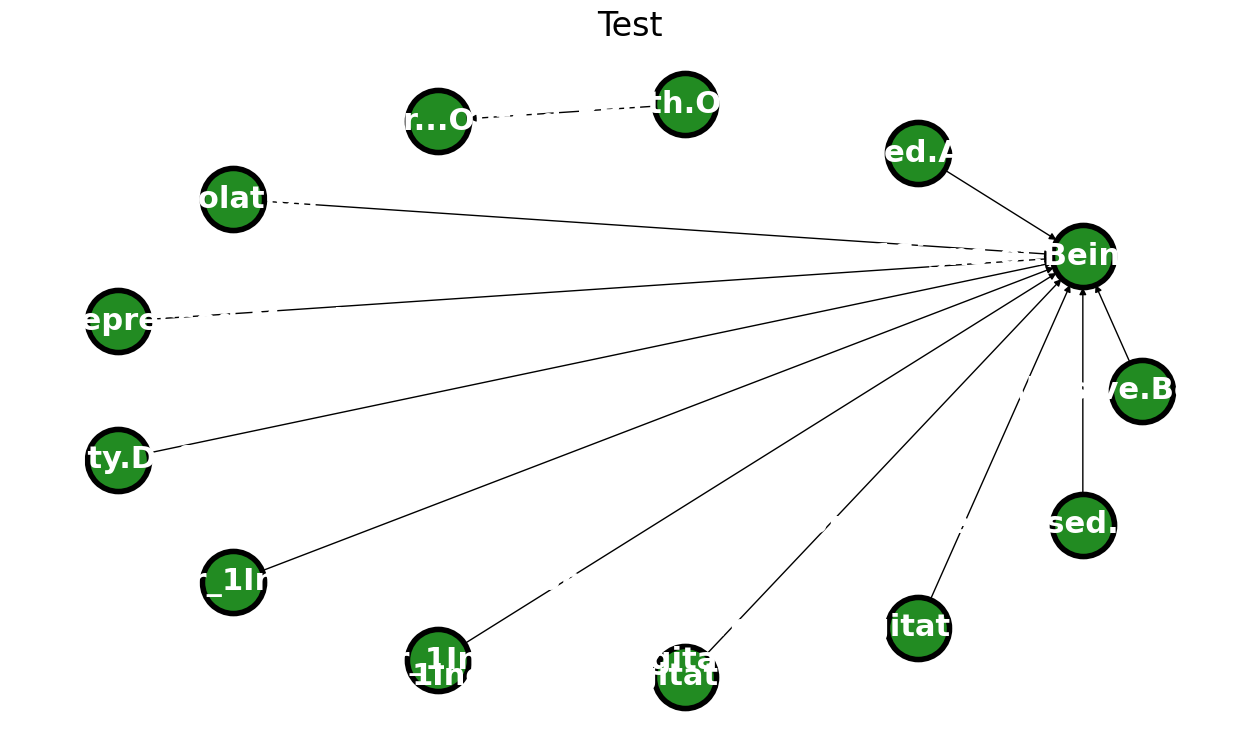

                                            rhs                          lhs  \
1                        [1Increased.Agitation]  [1Signs.of.Being.in.Crisis]   
7   [1Insider...Outsider, 1Increased.Agitation]  [1Signs.of.Being.in.Crisis]   
0                           [1Abusive.Behavior]  [1Signs.of.Being.in.Crisis]   
3                                  [1Isolation]  [1Signs.of.Being.in.Crisis]   
4                     [1Notably.Depressed.Mood]  [1Signs.of.Being.in.Crisis]   
5                           [2Insanity.Defense]  [1Signs.of.Being.in.Crisis]   
2                                [3Birth.Order]        [1Insider...Outsider]   
6     [1Abusive.Behavior, 1Increased.Agitation]  [1Signs.of.Being.in.Crisis]   
8            [1Increased.Agitation, 1Isolation]  [1Signs.of.Being.in.Crisis]   
9             [1Increased.Agitation, 1Planning]  [1Signs.of.Being.in.Crisis]   
10         [1Notably.Depressed.Mood, 1Leakage.]  [1Signs.of.Being.in.Crisis]   

        supp  conf  supp x conf      li

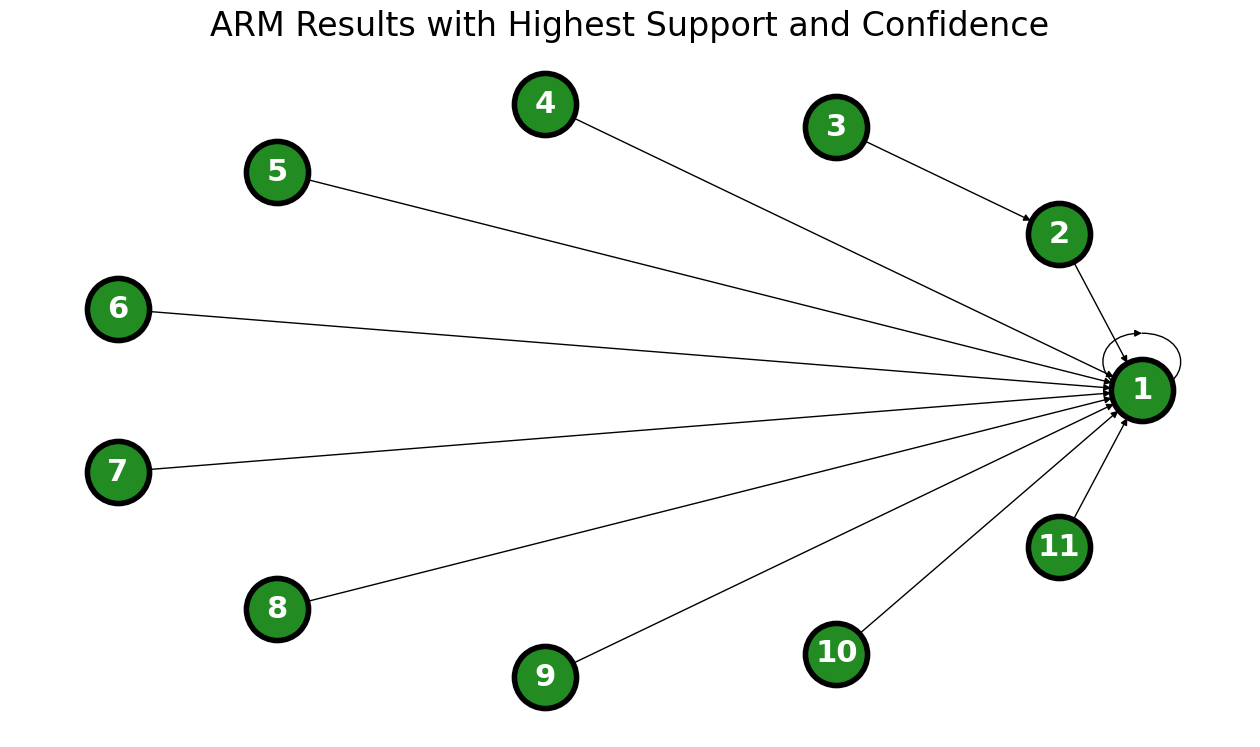

Index(['['1Abusive.Behavior']', '['1Increased.Agitation']', '['3Birth.Order']',
       '['1Isolation']', '['1Notably.Depressed.Mood']',
       '['2Insanity.Defense']',
       '['1Abusive.Behavior', '1Increased.Agitation']',
       '['1Insider...Outsider', '1Increased.Agitation']',
       '['1Increased.Agitation', '1Isolation']',
       '['1Increased.Agitation', '1Planning']',
       '['1Notably.Depressed.Mood', '1Leakage.']'],
      dtype='object')


In [120]:
results = list(apriori(msdb_data, min_support=0.55, min_confidence=1, min_lift=0, min_length=1))     # Don't go below 0.3 support 0.4 confidence
pd_results=reformat_results(results)
G=convert_to_network(pd_results)
plot_network(G, './test.png', "Test")

print(pd_results.sort_values('supp', ascending = False))

pd_results['rhs'], rhs_index = pd.factorize(pd_results['rhs'].astype(str))
pd_results['rhs'] = pd_results['rhs'].apply(lambda x: [str(x+1)])
pd_results['lhs'], lhs_index = pd.factorize(pd_results['lhs'].astype(str))
pd_results['lhs'] = pd_results['lhs'].apply(lambda x: [str(x+1)])

H=convert_to_network(pd_results)
plot_network(H, "./../../501-project-website/images/arm/top_conf.png", "ARM Results with Highest Support and Confidence")

print(rhs_index)